### Pregunta 3 - ¿Existen grupos de juegos con patrones similares que permitan agruparlos para recomendaciones?

#### Análisis Preliminar de los Datos

Dada la naturaleza de la pregunta, corresponde establecer un límite inferior tanto para el número de reviews mínimo, como para un score aceptable para generar recomendaciones. Para encontrar estos valores primero evaluaremos el mínimo de reviews que tiene que tener un juego para ser considerado en el análisis.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = './df_reduced.csv'
df = pd.read_csv(csv_path, low_memory=False)
df['total_players'] = (df['game_count_playing'] + df['game_count_comp'] + df['game_count_retired'])


Definimos la tasa de reseñas como la división entre el número de reseñas y el número total de jugadores. Esto nos entrega una métrica para evaluar la calidad de juegos evitando sesgos de popularidad.

In [21]:
df = df[df['total_players'] > 0]
df['tasa_reseñas'] = (df['review_review_count']/df['total_players'])
df = df[df['tasa_reseñas'] <= 1]


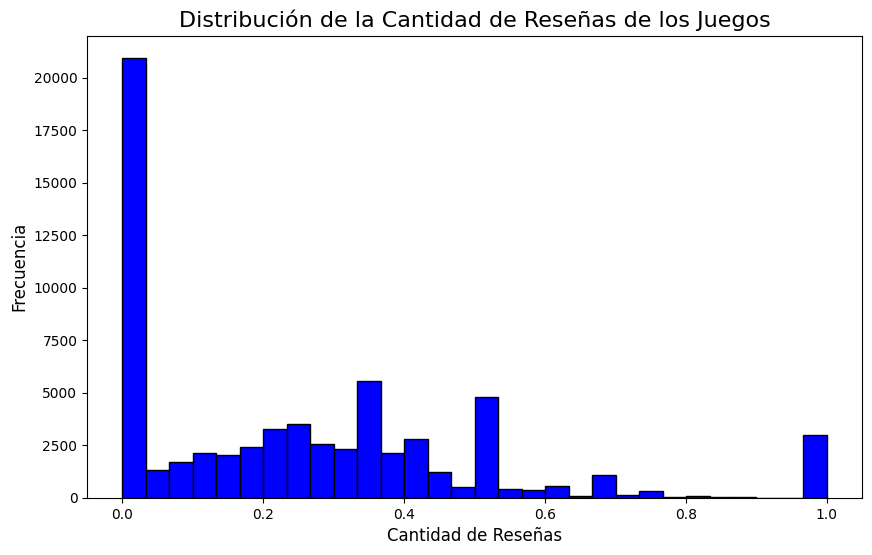

In [ ]:
# crear el gráfico
df_graph = df.dropna(subset=['tasa_reseñas'])

plt.figure(figsize=(10, 6))
plt.hist(df_graph['tasa_reseñas'], bins=30, color='blue', edgecolor='black')
plt.title('Distribución de la tasa de reseñas de los Juegos', fontsize=16)
plt.xlabel('Tasa de reseñas', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

Aqui debemos filtrar aquellos juegos que no tengan reseñas, dado que no podemos recomendar juegos que nunca han sido reseñados. Para ello además de descartar aquellos juegos sin review podemos desarrollar un análisis de los percentiles

In [23]:
# calculamos percentiles
percentil_25 = df['tasa_reseñas'].quantile(0.25)
percentil_50 = df['tasa_reseñas'].quantile(0.50)
percentil_75 = df['tasa_reseñas'].quantile(0.75)
percentil_90 = df['tasa_reseñas'].quantile(0.90)

print(f"Percentil 25: {percentil_25}")
print(f"Percentil 50: {percentil_50}")
print(f"Percentil 75: {percentil_75}")
print(f"Percentil 90: {percentil_90}")

Percentil 25: 0.0
Percentil 50: 0.2152777777777778
Percentil 75: 0.3830049261083744
Percentil 90: 0.5


Ante esto consideramos pertinente filtrar a partir del percentil 50, para tener una cantidad robusta de datos para nuestro análisis que cumplan el requisito de calidad.

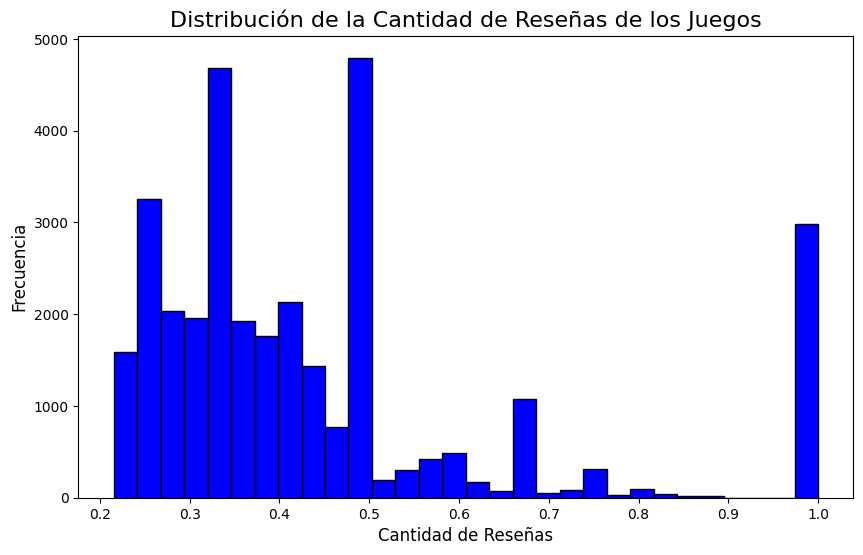

In [ ]:
# crear el gráfico
df = df[df['tasa_reseñas'] >= df['tasa_reseñas'].quantile(0.50)]


plt.figure(figsize=(10, 6))
plt.hist(df['tasa_reseñas'], bins=30, color='blue', edgecolor='black')
plt.title('Distribución de la tasa de reseñas de los juegos', fontsize=16)
plt.xlabel('Tasa de reseñas', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

#### Construcción del Conjunto de Datos
Con respecto a la construcción del conjunto de los datos, para el caso particular de esta pregunta se realiza una separación binaria en el atributo 'game_profile_genre' que permitirá tomar de forma granular el genero de un juego y no como conjunto.

In [25]:
csv_path = './df_reduced.csv'
df = pd.read_csv(csv_path, low_memory=False)

# binarización de los generos

import sys
import os

sys.stderr = open(os.devnull, 'w')


df['game_profile_genre'] = df['game_profile_genre'].fillna('')
df['generos_lista'] = df['game_profile_genre'].str.split(',')

todos_los_generos = []
for lista in df['generos_lista']:
    for genero in lista:
        genero = genero.strip()
        if genero != '' and genero not in todos_los_generos:
            todos_los_generos.append(genero)

for genero in todos_los_generos:
    df[genero] = 0 

for i in range(len(df)):
    for genero in df.loc[i, 'generos_lista']:
        genero = genero.strip()
        if genero in todos_los_generos:
            df.loc[i, genero] = 1

df = df.drop(columns=['generos_lista'])

sys.stderr = sys.__stderr__


# reviews positivas
df['total_players'] = (df['game_count_playing'] + df['game_count_comp'] + df['game_count_retired'])
df = df[df['total_players'] > 0]
df['tasa_reseñas'] = (df['review_review_count']/df['total_players'])
df = df[df['tasa_reseñas'] <= 1]
df = df[df['tasa_reseñas'] >= df['tasa_reseñas'].quantile(0.50)]
# luego de filtrar por juegos con buena tasa de reseñas, podemos eliminar este atributo
# df = df.drop(columns=['tasa_reseñas'])
df = df.drop(columns=['total_players'])
df.to_csv('df_reduced.csv', index=False)


#### Entrenamiento y evaluación del modelo

El primer acercamiento al problema se realizará tomando todos los datos disponibles, incluyendo la tasa de reseñas para dar una respuesta a la pregunta

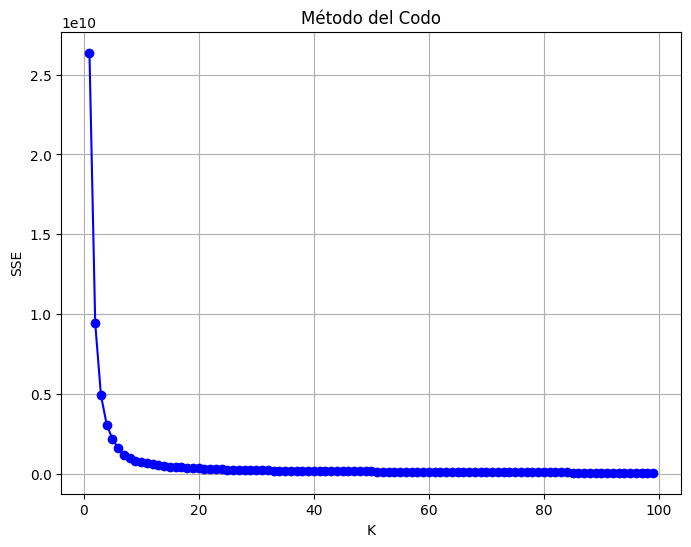

In [26]:
# busqueda del mejor k
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# filtramos para tener juegos con reviews suficientes y con un score bueno
df_filtered = df[(df['review_review_count'] > 0)]
features = df_filtered.select_dtypes(include=['float64', 'int64'])

k_range = range(1, 100)
sse = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o', color='b')
plt.title('Método del Codo')
plt.xlabel('K')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

Silhouette Score para KMeans (después de PCA): 0.8113683075013138
Cantidad de puntos de ruido en DBSCAN: 31851
Silhouette Score para DBScan (después de PCA): -0.7517675783274341


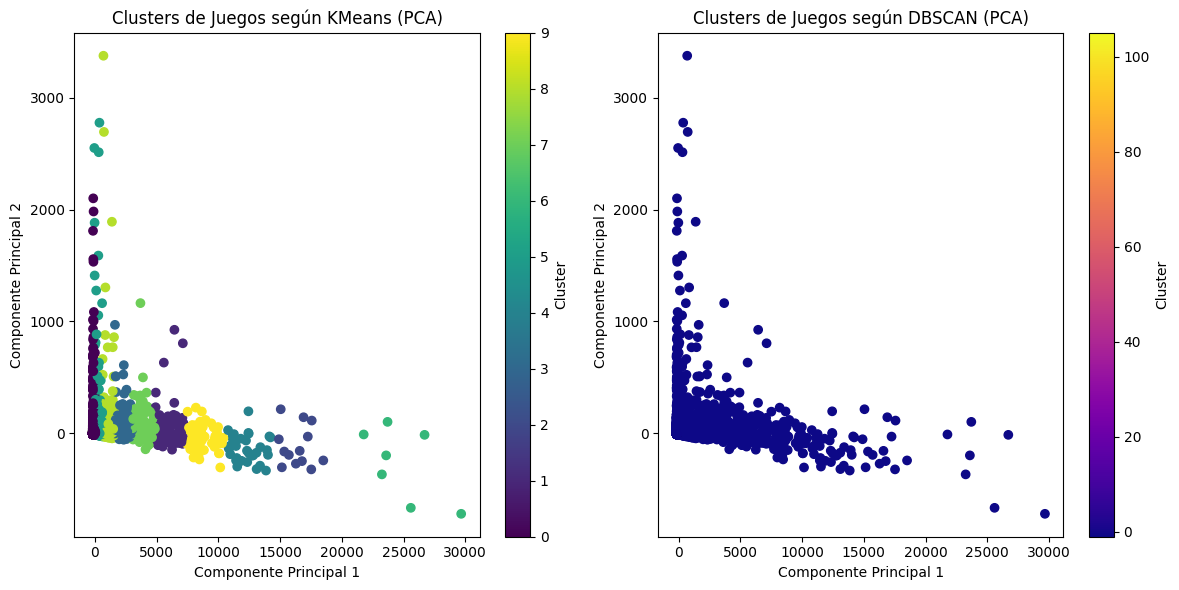

In [27]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN


pca = PCA(n_components=200)
pca_components = pca.fit_transform(features)


kmeans = KMeans(n_clusters=10, random_state=0)
df_filtered['cluster_kmeans'] = kmeans.fit_predict(pca_components)


dbscan = DBSCAN(eps=0.8, min_samples=5)
df_filtered['cluster_dbscan'] = dbscan.fit_predict(pca_components)

df_filtered['PCA1'] = pca_components[:, 0]
df_filtered['PCA2'] = pca_components[:, 1]


silhouette_kmeans = silhouette_score(pca_components, df_filtered['cluster_kmeans'])
print(f"Silhouette Score para KMeans (después de PCA): {silhouette_kmeans}")


n_ruido = sum(df_filtered['cluster_dbscan'] == -1)
print(f"Cantidad de puntos de ruido en DBSCAN: {n_ruido}")


if len(set(df_filtered['cluster_dbscan'])) > 1:
    silhouette_dbscan = silhouette_score(pca_components, df_filtered['cluster_dbscan'])
    print(f"Silhouette Score para DBScan (después de PCA): {silhouette_dbscan}")
else:
    print("DBSCAN no ha encontrado suficientes clusters válidos para calcular el Silhouette Score.")

plt.figure(figsize=(12, 6))

# gráfico PCA con kmeans
plt.subplot(1, 2, 1)
plt.scatter(df_filtered['PCA1'], df_filtered['PCA2'], c=df_filtered['cluster_kmeans'], cmap='viridis')
plt.title('Clusters de Juegos según KMeans (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')

# gráfico DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(df_filtered['PCA1'], df_filtered['PCA2'], c=df_filtered['cluster_dbscan'], cmap='plasma')
plt.title('Clusters de Juegos según DBSCAN (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

Ahora como variación tomaremos solo los generos de los juegos para realizar un análisis comparativo

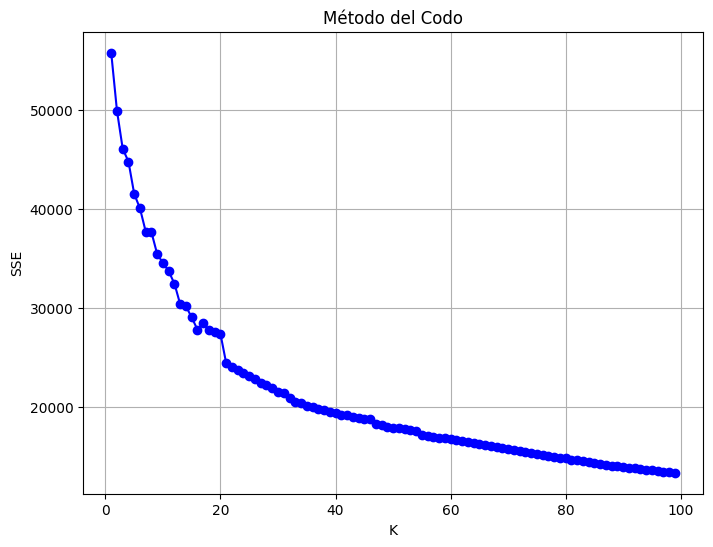

In [28]:
# busqueda del mejor k
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# filtramos para tener juegos con reviews suficientes y con un score bueno
df_filtered = df[(df['review_review_count'] > 0)]
genre_columns = df.columns[10:]
features = df_filtered[genre_columns]

k_range = range(1, 100)
sse = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o', color='b')
plt.title('Método del Codo')
plt.xlabel('K')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

Silhouette Score para KMeans (después de PCA): 0.3843175276415822
Cantidad de puntos de ruido en DBSCAN: 3805
Silhouette Score para DBScan (después de PCA): 0.6475837186108544


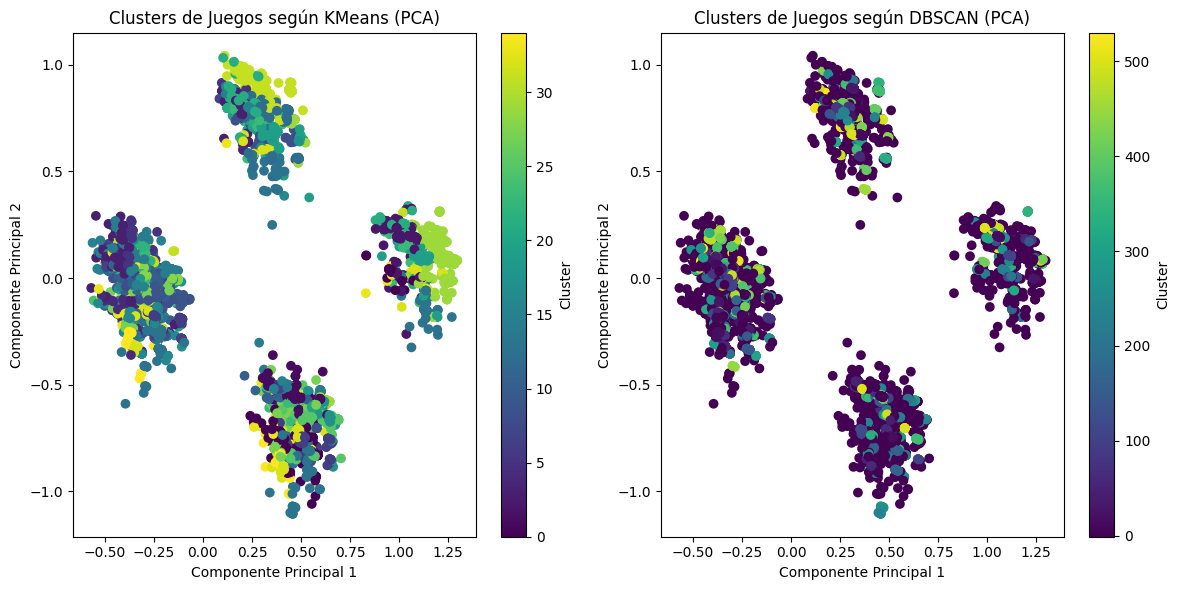

In [38]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN

# aplicamos kmeans
kmeans = KMeans(n_clusters=35, random_state=0)
score_kmeans = kmeans.fit(features).score(features)
df_filtered['cluster_kmeans'] = kmeans.fit_predict(features)

# aplicamos dbscan
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_filtered['cluster_dbscan'] = dbscan.fit_predict(features)

# reducimos dimensiones para graficar y ver los clusters
pca = PCA(n_components=100)
pca_components = pca.fit_transform(features)

df_filtered['PCA1'] = pca_components[:, 0]
df_filtered['PCA2'] = pca_components[:, 1]


silhouette_kmeans = silhouette_score(pca_components, df_filtered['cluster_kmeans'])
print(f"Silhouette Score para KMeans (después de PCA): {silhouette_kmeans}")


n_ruido = sum(df_filtered['cluster_dbscan'] == -1)
print(f"Cantidad de puntos de ruido en DBSCAN: {n_ruido}")


if len(set(df_filtered['cluster_dbscan'])) > 1:
    silhouette_dbscan = silhouette_score(pca_components, df_filtered['cluster_dbscan'])
    print(f"Silhouette Score para DBScan (después de PCA): {silhouette_dbscan}")
else:
    print("DBSCAN no ha encontrado suficientes clusters válidos para calcular el Silhouette Score.")



plt.figure(figsize=(12, 6))

# grfico pca
plt.subplot(1, 2, 1)
plt.scatter(df_filtered['PCA1'], df_filtered['PCA2'], c=df_filtered['cluster_kmeans'], cmap='viridis')
plt.title('Clusters de Juegos según KMeans (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')

# grafico dbscan
plt.subplot(1, 2, 2)
plt.scatter(df_filtered['PCA1'], df_filtered['PCA2'], c=df_filtered['cluster_dbscan'], cmap='viridis')
plt.title('Clusters de Juegos según DBSCAN (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

In [30]:
# funcion que nos permite ver los nombres asociados a un cluster particular
def juegos_por_cluster(df, cluster_num, type='dbscan'):
    juegos_cluster = df[df[f'cluster_{type}'] == cluster_num]['game_game_name']
    
    if juegos_cluster.empty:
        print(f"No se encontraron juegos en el cluster {cluster_num}.")
    else:
        print(f"Juegos en el cluster {cluster_num}, usando {type}:")
        for juego in juegos_cluster:
            print(f"- {juego}")



In [31]:

print("Ejecución con kmeans")
juegos_por_cluster(df_filtered, 12, 'kmeans')      

Ejecución con kmeans
Juegos en el cluster 12, usando kmeans:
- 5 Days a Stranger
- 80 Days: Around the World Adventure
- 9:05
- A Duck Has An Adventure
- A Mind Forever Voyaging
- A Tale of Two Kingdoms
- A Vampyre Story
- Ace Attorney Investigations: Miles Edgeworth
- Actual Sunlight
- Adventure Time: Hey Ice King! Why'd You Steal Our Garbage?!
- Aether
- Again: Interactive Crime Novel
- Agatha Christie: And Then There Were None
- Agatha Christie: Evil Under the Sun
- Agatha Christie: Murder on the Orient Express
- Agatha Christie: The ABC Murders
- Alex Kidd: High-Tech World
- Alida
- Alien Incident
- Alternativa
- Amazing Adventures: The Forgotten Ruins
- Amazon Trail II
- AMBER: Journeys Beyond
- The Search for Amelia Earhart
- Amerzone: The Explorer's Legacy
- Animorphs
- Ankh 2: Heart of Osiris
- Ao Oni
- Apollo Justice: Ace Attorney
- Atlantis: The Lost Tales
- Back to the Future
- Beavis and Butt-head in Virtual Stupidity
- Betrapped!
- Atlantis III: The New World
- Beyond Time

In [32]:

print("Ejecución con dbscan")
juegos_por_cluster(df_filtered, 12, 'dbscan')      

Ejecución con dbscan
Juegos en el cluster 12, usando dbscan:
- 11eyes ~Tsumi to Batsu to Aganai no Shoujo~
- Aselia the Eternal
- Bakemonogatari Portable
- Cartagra ~Tsuki kurui no Yamai~
- Chaos;Head
- Crimsoness
- Cross Channel
- Deus Machina Demonbane
- Digital: A Love Story
- Don't take it personally, babe, it just ain't your story
- Enzai: Falsely Accused
- Ever17: The Out of Infinity
- Fading Hearts
- Fatal Hearts
- Fate/Stay Night
- Fortune Arterial
- Harvey Birdman: Attorney at Law
- Heileen: Sail Away
- Higanbana no Saku Yoru ni: The First Night
- Higurashi When They Cry
- Higurashi When They Cry Kai
- Hourglass of Summer
- Juniper's Knot
- Kagetsu Tohya
- Katawa Shoujo
- Kikokugai: The Cyber Slayer
- Kirakira
- Kodomo no Tame no Yomi Kikase: Ehon de Asobou 1-Kan
- Little Busters!
- Joe Dever's Lone Wolf - Book I: Flight From The Dark
- Joe Dever's Lone Wolf - Book II: Fire On The Water
- Lux-Pain
- Maji de Watashi ni Koi Shinasai!
- Mirai Nikki: The 13th Diary Holder
- Monste

Evaluación del modelo

#### Conclusiones Preliminares

El análisis exploratorio realizado, sustentado en la binarización de géneros y filtros de reseña y puntajes, permitió identificar agrupamientos coherentes entre titulos con perfiles de genero similares. Esta estrategia demostró ser efectiva para estructurar el conjunto de datos de manera significativa, enfocandose en juegos que, por su nivel de recepción y evaluación, representan un subconjunto más confiable del universo total.

La aplicación del Método del Codo para ambos métodos implicó un análisis distinto, en primer lugar para el análisis completo se tiene una gráfica con una pendiente pronunciada que alcanza un punto de inflexión cercano a 10 clusters mientras que para el método que sólo considera los géneros se tiene una curva más suave que no presentó un punto de inflexión claramente definido, en este caso se considero que 35 clusters corresponde a un valor óptimo. Estas cantidades lograron equilibrar tanto la representación de la diversidad de combinaciones de genero, como la cohesión interna dentro de cada grupo. Clusters como el seleccionado nos dan cuenta de la autenticidad de los resultados obtenidos, ya que agrupan videojuegos con una gran carga narrativa, acción y tercera persona. Esto nos da cuenta de la utilidad del enfoque basado en géneros binarios como una herramienta potencial para sistemas de recomendación.

En cuanto a las técnicas de agrupamiento, pimero tenemos la ejecución dónde se consideró toda la data que evidencia una buena relación de clusters luego de entregando un silhouette score para kmeans de 0.811 y para dbscan de -0.75. En el análisis exclusivo de los géneros se obtiene un silhouette score de 0.38 para kmeans y 0.65 para dbscan. Esta información nos permite concluir que el mejor análisis para recomendar juegos se debe realizar utilizando kmeans con todos los datos, ya que si se compara con los clusters obtenidos en kmeans/dbscan en el caso de los generos podemos observar a través de los gráficos que no logra identificar correctamente los grupos.

#### Posibles Mejoras

Una de las mejoras más relevantes consiste en ampliar el espacio de características más allá de la información proporcionada, incorporar variables adicionales permitiría capturar aspectos que hoy quedan fuera del análisis. Por ejemplo, integrar métricas como el tiempo promedio de speedrun, su desviación estándar o incluso el tipo de final alcanzado, podría diferenciar entre juegos de ritmo vertiginoso y aquellos con un desarrollo más pausado, incluso dentro de un mismo género.

A la vez, añadir información contextual sobre las plataformas aportaría una capa adicional sobre la experiencia de juego. La inclusión de análisis de sentimiento o técnicas de extracción de temas a partir de reseñas y descripciones textuales podría reflejar la percepción real de la comunidad, identificando atributos más subjetivos que no son captados por los géneros formales. Esto ayudaría, por ejemplo, a distinguir entre un plataformero clásico con un juego del estilo metroidvania, que aunque comparten aspectos similares, sus experiencias de juego son en escencia muy diferentes.

En cuanto a los algoritmos, explorar con modelos jerárquicos podría revelar relaciones más finas entre géneros y subgéneros, ya que con los modelos actuales no queda tan claro el punto de inflexión en juegos que tengan una combinación de generos altamente cohesionados, lo que si es mucho mas claro al considerarlos jerarquicamente.

Por ultimo,  incluir encuestas a jugadores para verificar que los clusters resultantes no solo sean coherentes desde un punto de vista estadístico, sino también relevantes y útiles desde la experiencia del usuario.